## Notebook for analysing the SNNs trained on MNIST temporal sequences MNIST [SNNTorch]

In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import datetime

import torch
from torch.utils.data import DataLoader

import snntorch as snn

from models import SNN1
from datasets import MNISTSequencesDataset, NormaliseToZeroOneRange

from SNNCustomConfig import SNNCustomConfig

In [2]:
# Setting random seeds
torch.manual_seed(0)
np.random.seed(0)

#### Load the last / specified model state

In [16]:
config = SNNCustomConfig(model_name="SNN1", dataset_name="mnist_sequences_10hz",
                         configuration_name="config1", continue_training=True)

ConfigParser: Loading configuration from config1.txt


In [4]:
device = torch.device(config.params["torch_device"])
ingest_torch_dtype = torch.uint8
ingest_numpy_dtype = np.uint8

dtype = torch.float32

tao_mem = config.params["membrane_time_constant_tao"] # 10ms membrane time constant
timestep = 1/config.params["dataset_sampling_frequency"]
beta = np.exp(-timestep / tao_mem)

# Data ingest and network initialisation
normalise_transform = NormaliseToZeroOneRange(dtype=dtype)
mnist_dataset = MNISTSequencesDataset(config.dirs["training"], config.params["LIF_linear_features"], ingest_numpy_dtype, ingest_torch_dtype, transform=normalise_transform)
train_loader = DataLoader(mnist_dataset, batch_size=config.params["batch_size"], shuffle=True, num_workers=config.params["dataloader_num_workers"])

config.data_shape = next(iter(train_loader)).shape

model = SNN1(num_steps=config.data_shape[1], beta=beta, LIF_linear_features=config.params["LIF_linear_features"], reset_mechanism=config.params["reset_mechanism"], dtype=dtype).to(device).to(dtype)

optimizer = config.get_optimizer(model)
scheduler = config.get_scheduler(optimizer)

In [5]:
current_dir = config.weights_save_dir/config.configuration_name
print('Files inside',current_dir)
os.listdir(current_dir)

Files inside /home/ikharitonov/RANCZLAB-NAS/iakov/produced/mnist_sequence_checkpoints/SNN1_mnist_sequences_10hz/config1


['metrics.csv',
 'lr_metrics.csv',
 'SNN1_mnist_sequences_10hz_i_0_epoch_28_loss_0.061.pth',
 'config1.txt',
 'SNN1_mnist_sequences_10hz_i_0_epoch_1_loss_0.069.pth',
 'SNN1_mnist_sequences_10hz_i_0_epoch_25_loss_0.061.pth']

In [6]:
model, optimizer, checkpoint = config.iteration_begin_step(model, optimizer, specify_weights_file=None)
loss_hist = checkpoint['loss_history']

Continuing training from file: /home/ikharitonov/RANCZLAB-NAS/iakov/produced/mnist_sequence_checkpoints/SNN1_mnist_sequences_10hz/config1/SNN1_mnist_sequences_10hz_i_0_epoch_28_loss_0.061.pth | starting epoch: 29
615,440 total parameters.
615,440 trainable parameters.


In [7]:
checkpoint.keys()

dict_keys(['epoch', 'model_state', 'optimizer_state', 'scheduler_state', 'loss_history', 'training_accuracy', 'testing_accuracy'])

#### Looking at loss

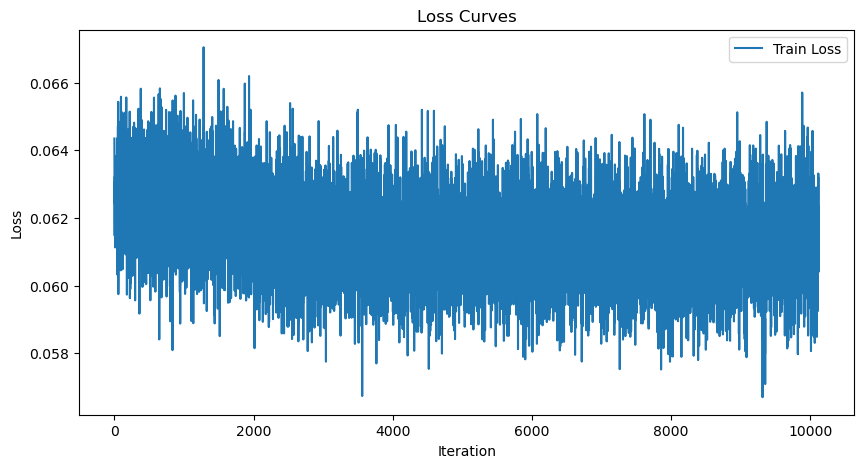

In [8]:
# %matplotlib widget
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plt.xlim([0,1700])
# plt.savefig()
plt.show()

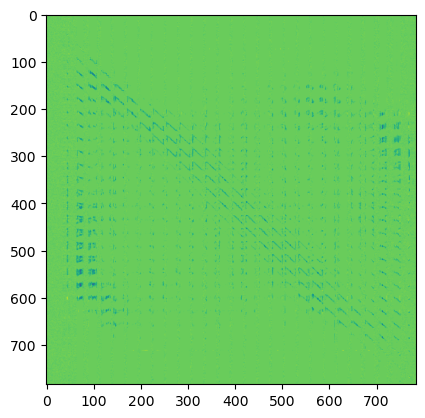

In [9]:
plt.figure()
plt.imshow(model.lif1.recurrent.weight.data.cpu().numpy())
plt.show()

#### Looking at network dynamics

In [10]:
model.eval()

batch_size = config.params["batch_size"]
batch_data_shape = config.data_shape

random_data = next(iter(train_loader)).to(device)
spk_rec, mem_rec = model(random_data)

dim_size = int(config.params["LIF_linear_features"]**0.5)


arr1 = random_data[:,:,:].reshape((batch_size,batch_data_shape[1],dim_size,dim_size)).detach().cpu().numpy()[0,:,:,:]
arr2 = mem_rec.reshape((batch_size,batch_data_shape[1],dim_size,dim_size)).detach().cpu().numpy()[0,:,:,:]
arr3 = spk_rec.reshape((batch_size,batch_data_shape[1],dim_size,dim_size)).detach().cpu().numpy()[0,:,:,:]

In [11]:
# # Animation takes long time to load
# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 150  
# plt.ioff()

# fig, ax = plt.subplots(nrows=1,ncols=3)

# def animate(t):
#     plt.cla()
#     ax[0].set_title(f'Frame {t}: input', fontsize=5)
#     ax[0].imshow(arr1[t,:,:])
#     ax[1].set_title(f'Frame {t}: membrane voltage', fontsize=5)
#     ax[1].imshow(arr2[t,:,:])
#     ax[2].set_title(f'Frame {t}: unit spiking', fontsize=5)
#     ax[2].imshow(arr3[t,:,:])

# anim = matplotlib.animation.FuncAnimation(fig, animate, frames=batch_data_shape[1])
# anim
# # writervideo = matplotlib.animation.ImageMagickWriter(fps=60) 
# # anim.save(f'{weights_filename}_movie.gif') 
# # plt.close() 

In [12]:
mem_rec.shape

torch.Size([20, 105, 784])

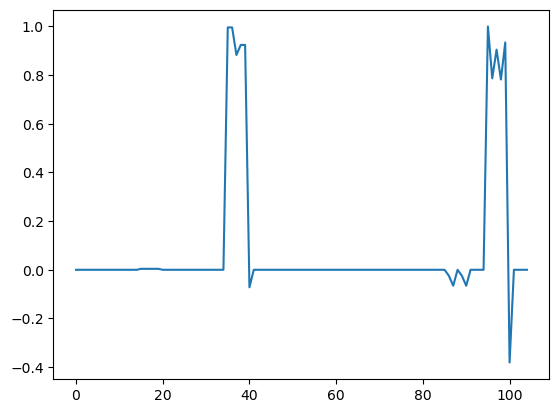

In [13]:
plt.figure()
plt.plot(mem_rec[0,:,300].detach().cpu().numpy())
plt.show()

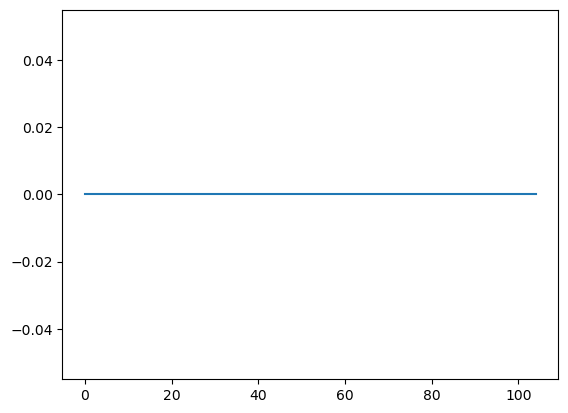

In [14]:
plt.figure()
plt.plot(spk_rec[0,:,300].detach().cpu().numpy())
plt.show()

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(mem_rec[0].detach().cpu().numpy())
print(pca.explained_variance_ratio_)
comps = pca.transform(mem_rec[0].detach().cpu().numpy())
print(comps.shape)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
plt.figure()
plt.scatter(np.arange(batch_data_shape[1]), comps[:,0])
plt.show()